terminal: https://python.land/virtual-environments/virtualenv

yingliu@Yings-Air fraud detection in healthcare % source healthfraud/bin/activate

In [206]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from matplotlib.ticker import PercentFormatter
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC  
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc , f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer , StandardScaler





#### Read data 

In [156]:
# data train include provider ID and labels
Train = pd.read_csv("data/Train-1542865627584.csv")

# include beneficiary KYC details like health conditions,region
Train_Beneficiarydata = pd.read_csv("data/Train_Beneficiarydata-1542865627584.csv")

# include the claims filed for those patients who are admitted in the hospitals
Train_Inpatientdata=pd.read_csv("data/Train_Inpatientdata-1542865627584.csv")

# include the claims filed for those patients who visit hospitals and not admitted in it.
Train_Outpatientdata=pd.read_csv("data/Train_Outpatientdata-1542865627584.csv")


In [157]:
print("Train\n", Train.shape)
print("Train_Beneficiarydata\n", Train_Beneficiarydata.shape)
print("Train_Inpatientdata\n", Train_Inpatientdata.shape)
print("Train_Outpatientdata\n", Train_Outpatientdata.shape)


Train
 (5410, 2)
Train_Beneficiarydata
 (138556, 25)
Train_Inpatientdata
 (40474, 30)
Train_Outpatientdata
 (517737, 27)


#### Exploratory Data Analysis before Data Preprocessing

##### Inpatient - Procedure Code, Provider, Hospital Stay, Diagnosis Code

In [158]:
# figure out the most common procedure code and diagnosis code for inpatient cases
print('inpatient columns:\n',  Train_Inpatientdata.columns)
Train_Inpatientdata.head(5)

inpatient columns:
 Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6'],
      dtype='object')


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN


In [159]:
# create a dataframe for concatinating all Procedure Code columns 
inpatient_proc = pd.DataFrame(columns = ['ProcedureCode'])
inpatient_proc['ProcedureCode'] = pd.concat([Train_Inpatientdata["ClmProcedureCode_1"], 
                                           Train_Inpatientdata["ClmProcedureCode_2"],
                                           Train_Inpatientdata["ClmProcedureCode_3"],
                                           Train_Inpatientdata["ClmProcedureCode_4"], 
                                           Train_Inpatientdata["ClmProcedureCode_5"], 
                                           Train_Inpatientdata["ClmProcedureCode_6"]], axis=0, sort=True).dropna()

print(inpatient_proc.shape)
inpatient_proc.head(5)

(29692, 1)


,ProcedureCode
1,7092.0
3,331.0
4,3893.0
5,863.0
6,4576.0


In [160]:
# create a dataframe for provider, hospital stay length
ip_provider = pd.DataFrame(columns = ['Provider', 'Hperiod'])
ip_provider ['Provider'] = Train_Inpatientdata['Provider'].dropna()

startdate = pd.to_datetime(Train_Inpatientdata.AdmissionDt)
enddate = pd.to_datetime(Train_Inpatientdata.DischargeDt)
ip_provider ['Hperiod'] = (enddate - startdate).dt.days + 1

print(ip_provider.shape)
ip_provider.head(5)

(40474, 2)


,Provider,Hperiod
0,PRV55912,7
1,PRV55907,3
2,PRV56046,4
3,PRV52405,9
4,PRV56614,18


In [161]:
# create a dataframe for concatinating all dx Code columns 
inpatient_dx = pd.DataFrame(columns = ['DiagnosisCode'])
inpatient_dx['DiagnosisCode'] = pd.concat([Train_Inpatientdata["ClmDiagnosisCode_1"], 
                                           Train_Inpatientdata["ClmDiagnosisCode_2"],
                                           Train_Inpatientdata["ClmDiagnosisCode_3"],
                                           Train_Inpatientdata["ClmDiagnosisCode_4"], 
                                           Train_Inpatientdata["ClmDiagnosisCode_5"], 
                                           Train_Inpatientdata["ClmDiagnosisCode_6"],
                                           Train_Inpatientdata["ClmDiagnosisCode_7"],
                                           Train_Inpatientdata["ClmDiagnosisCode_8"],
                                           Train_Inpatientdata["ClmDiagnosisCode_9"],
                                           Train_Inpatientdata["ClmDiagnosisCode_10"],], axis=0, sort=True).dropna()

print(inpatient_dx.shape)
inpatient_dx.head(5)

(327328, 1)


,DiagnosisCode
0,1970
1,6186
2,29623
3,43491
4,042


In [162]:
def analyse_cat_columns(dataset,
                        col_to_analyse='' ,
                        prefix = '',title = 'Distribution in percentage ',
                        top_val = 30, 
                        y_lim = np.arange(0,8),
                        color ='blue'):
    """This functiom plot bar graog for categorical column"""
    #get top 30 procedure codes with its count
    val_counts_ = dataset[col_to_analyse].value_counts()
        
    val_counts_df = val_counts_.to_frame() #store this information in dataframe
    val_counts_df[col_to_analyse] = val_counts_df.index
    
    #since simply plotting bar plots for count of each val would not give much information,so it better to plot in percentage.
    val_counts_df[col_to_analyse] = prefix + val_counts_df[col_to_analyse].astype(str)
    val_counts_df['Percentage'] = (val_counts_df['count']/sum(val_counts_df['count']))*100
    
    val_counts_df = val_counts_df.head(top_val)
    
    val_counts_df.plot(x =col_to_analyse, y='Percentage', kind='bar', color = color, \
                        title=title, figsize=(15,5),yticks=y_lim,grid = False )
    
    plt.gca().yaxis.set_major_formatter(PercentFormatter(100))

    plt.show()

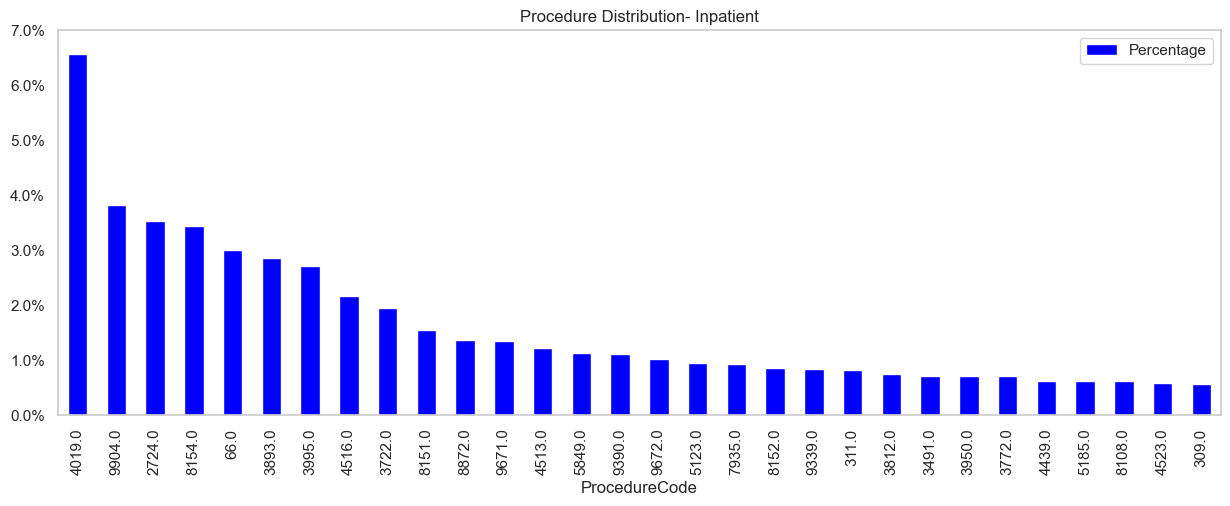

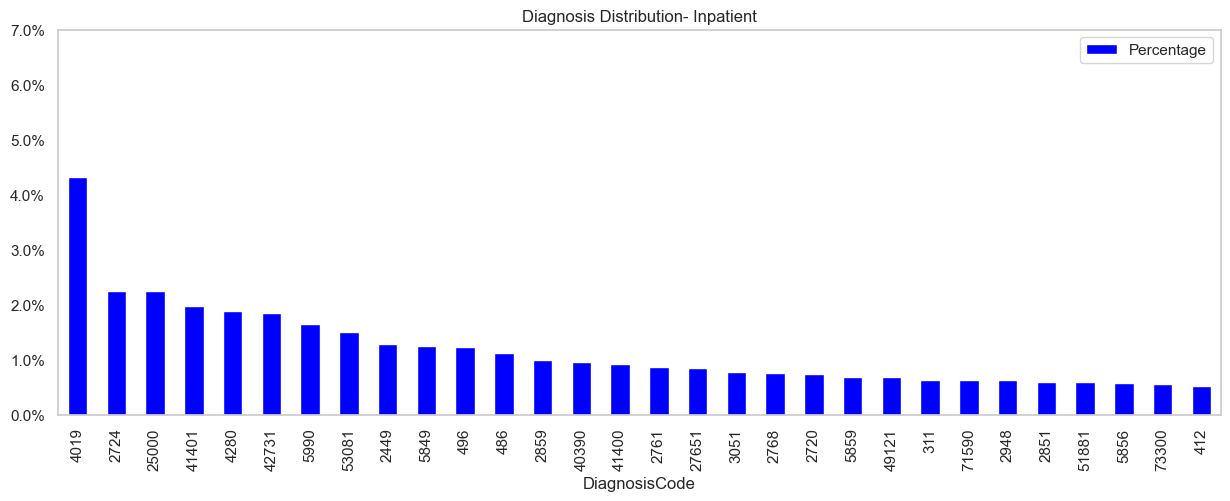

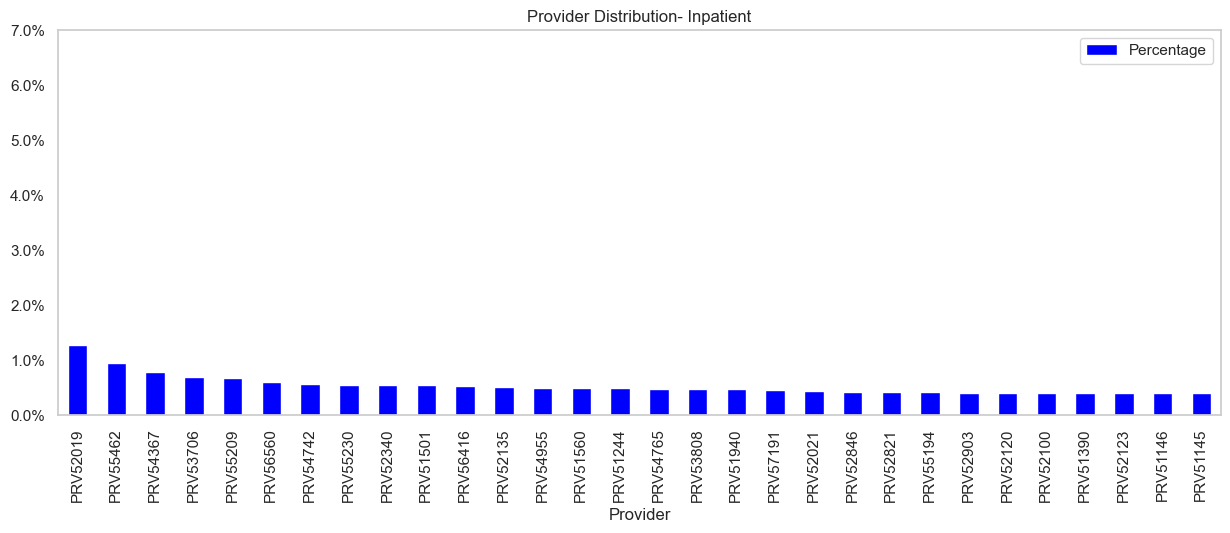

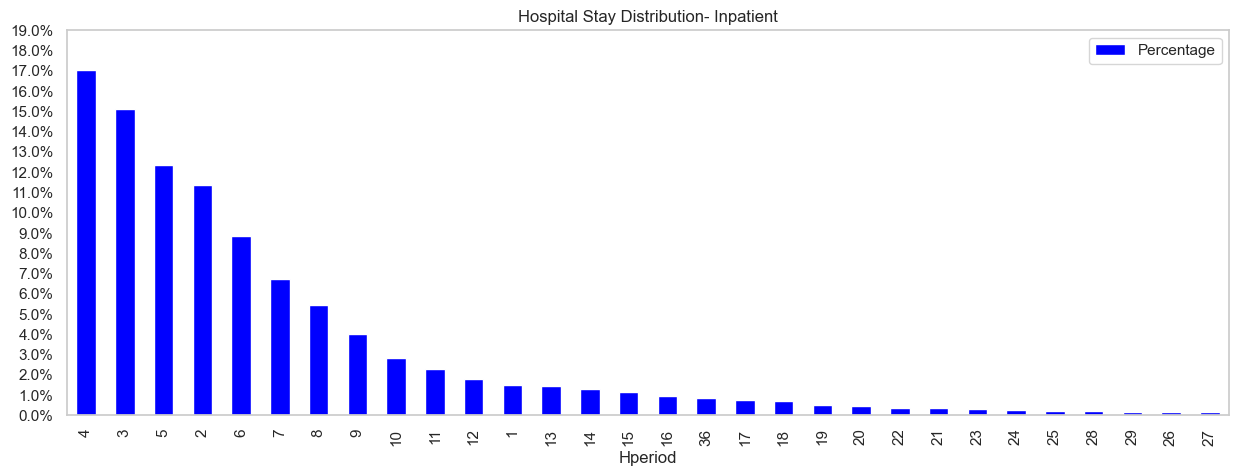

In [163]:
analyse_cat_columns(dataset = inpatient_proc, col_to_analyse='ProcedureCode', title = 'Procedure Distribution- Inpatient')
analyse_cat_columns(dataset = inpatient_dx, col_to_analyse='DiagnosisCode', title = 'Diagnosis Distribution- Inpatient')
analyse_cat_columns(dataset = ip_provider, col_to_analyse='Provider', title = 'Provider Distribution- Inpatient')
analyse_cat_columns(dataset = ip_provider, col_to_analyse='Hperiod', y_lim = np.arange(0,20), title = 'Hospital Stay Distribution- Inpatient')


##### Inpatient - Claim Amount

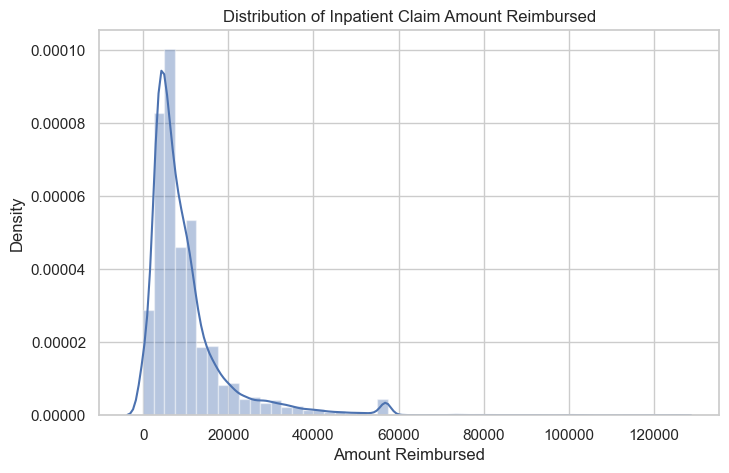

In [164]:
plt.figure(figsize=(8, 5))
sns.distplot(Train_Inpatientdata.InscClaimAmtReimbursed)

# Adding title and labels
plt.title('Distribution of Inpatient Claim Amount Reimbursed')
plt.xlabel('Amount Reimbursed')
plt.ylabel('Density')

# Show plot
plt.show()

##### Conclusions

1. The top procedure is 4019.0. There are 6% patients undergoing this procedure. Based on ICD-9 Code, 4019 is Hypertension NOS (Unspecified essential hypertension).

2. The top diagnosis is also 4019. There are around 4.5% patients diagnosed as Hypertension NOS (Unspecified essential hypertension).

3. In the inpatient claim, providers are evenly distributed. There is no specific providers which submitted more claims than others.

4. More than 90% of paitients stayed in hospital less than 10 days.

5. The distribution of amount reimbursed in the inpatient claim seems like a log normal distribtion. The majority of amount falls between 0 and 20,000.

##### Outpatient - Procedure Code

In [165]:
# figure out the most common procedure code and diagnosis code for outpatient cases
print('outpatient columns:\n',  Train_Outpatientdata.columns)
Train_Outpatientdata.head(5)

outpatient columns:
 Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode'],
      dtype='object')


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,71947


In [166]:
# create a dataframe for concatinating all Procedure Code columns 
outpatient_proc = pd.DataFrame(columns = ['ProcedureCode'])
outpatient_proc['ProcedureCode'] = pd.concat([Train_Outpatientdata["ClmProcedureCode_1"], 
                                           Train_Outpatientdata["ClmProcedureCode_2"],
                                           Train_Outpatientdata["ClmProcedureCode_3"],
                                           Train_Outpatientdata["ClmProcedureCode_4"], 
                                           Train_Outpatientdata["ClmProcedureCode_5"], 
                                           Train_Outpatientdata["ClmProcedureCode_6"]], axis=0, sort=True).dropna()

print(outpatient_proc.shape)
outpatient_proc.head(5)

(204, 1)


,ProcedureCode
8167,9672.0
9326,4573.0
14740,66.0
30435,66.0
35839,5123.0


In [167]:
# create a dataframe for concatinating all dx Code columns 
outpatient_dx = pd.DataFrame(columns = ['DiagnosisCode'])
outpatient_dx['DiagnosisCode'] = pd.concat([Train_Outpatientdata["ClmDiagnosisCode_1"], 
                                           Train_Outpatientdata["ClmDiagnosisCode_2"],
                                           Train_Outpatientdata["ClmDiagnosisCode_3"],
                                           Train_Outpatientdata["ClmDiagnosisCode_4"], 
                                           Train_Outpatientdata["ClmDiagnosisCode_5"], 
                                           Train_Outpatientdata["ClmDiagnosisCode_6"],
                                           Train_Outpatientdata["ClmDiagnosisCode_7"],
                                           Train_Outpatientdata["ClmDiagnosisCode_8"],
                                           Train_Outpatientdata["ClmDiagnosisCode_9"],
                                           Train_Outpatientdata["ClmDiagnosisCode_10"],], axis=0, sort=True).dropna()

print(outpatient_dx.shape)
outpatient_dx.head(5)

(1353388, 1)


,DiagnosisCode
0,78943
1,6115
2,2723
3,71988
4,82382


In [168]:
# create a dataframe for provider, claim length
op_provider = pd.DataFrame(columns = ['Provider', 'Cperiod'])
op_provider ['Provider'] = Train_Outpatientdata['Provider'].dropna()

startdate = pd.to_datetime(Train_Outpatientdata.ClaimStartDt)
enddate = pd.to_datetime(Train_Outpatientdata.ClaimEndDt)
op_provider ['Cperiod'] = (enddate - startdate).dt.days + 1

print(op_provider.shape)
op_provider.head(5)

(517737, 2)


,Provider,Cperiod
0,PRV56011,1
1,PRV57610,1
2,PRV57595,1
3,PRV56011,1
4,PRV56011,1


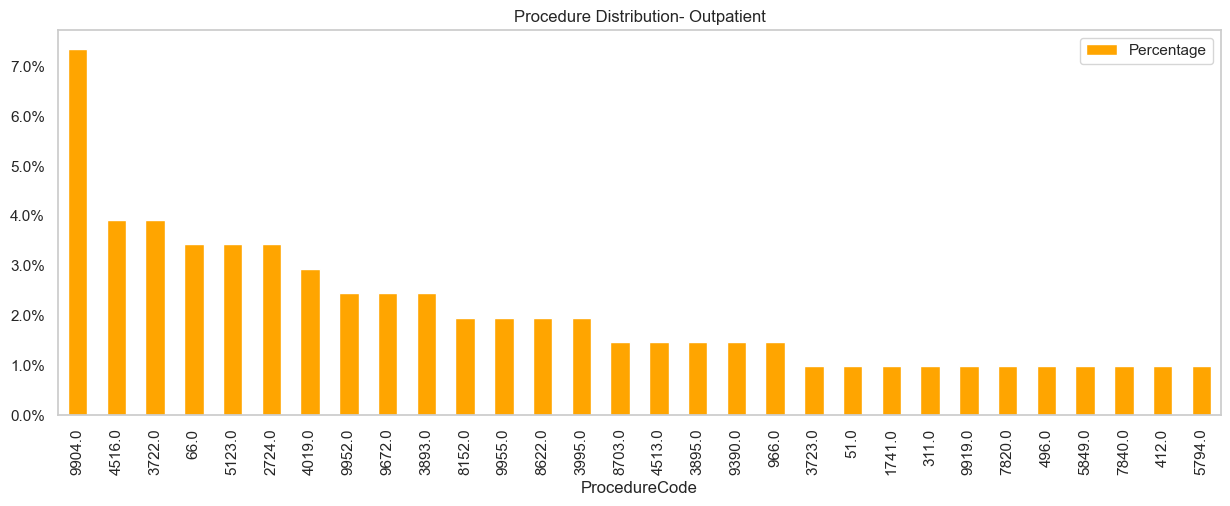

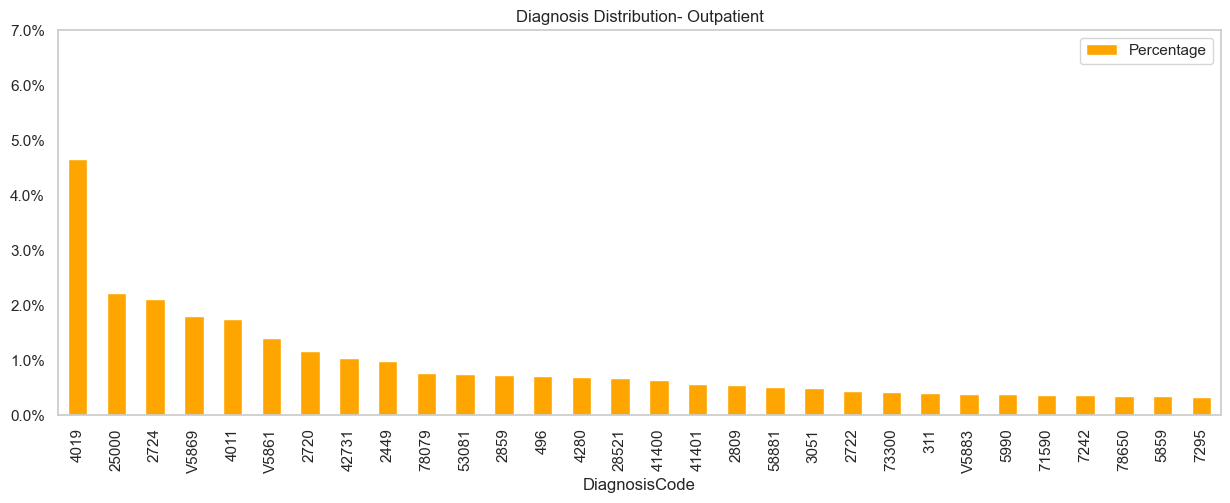

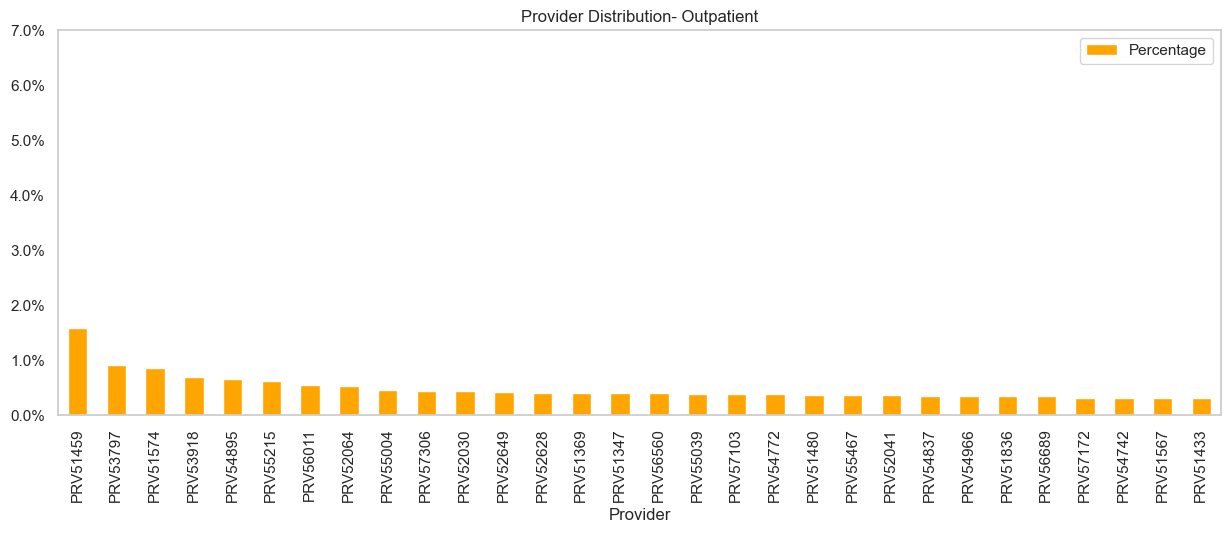

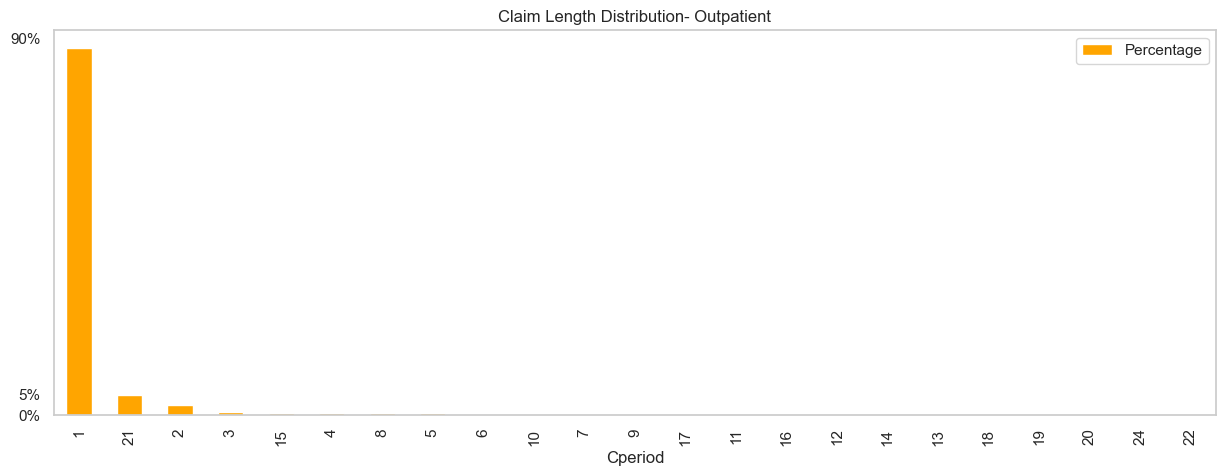

In [169]:
analyse_cat_columns(dataset = outpatient_proc, col_to_analyse='ProcedureCode', title = 'Procedure Distribution- Outpatient', color ='orange')
analyse_cat_columns(dataset = outpatient_dx, col_to_analyse='DiagnosisCode', title = 'Diagnosis Distribution- Outpatient', color ='orange')
analyse_cat_columns(dataset = op_provider, col_to_analyse='Provider', title = 'Provider Distribution- Outpatient', color ='orange')
analyse_cat_columns(dataset = op_provider, col_to_analyse='Cperiod', y_lim = (0,90,5), title = 'Claim Length Distribution- Outpatient', color ='orange')


##### Outpatient - Claim Amount

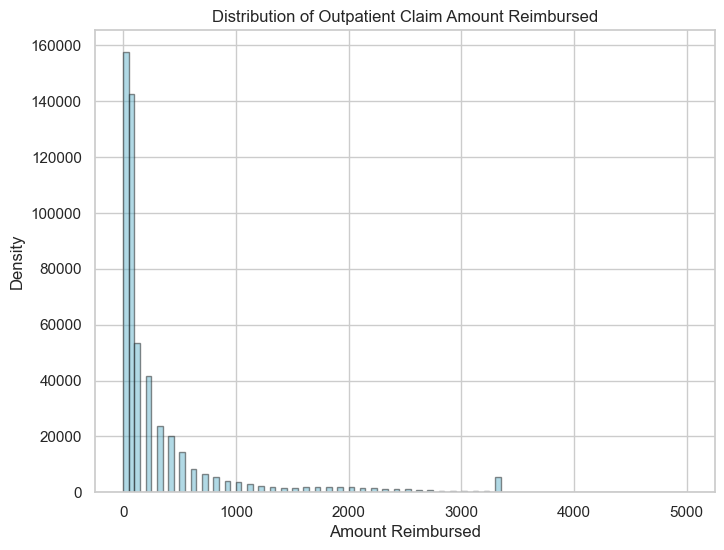

In [170]:
plt.figure(figsize=(8, 5))

Train_Outpatientdata['InscClaimAmtReimbursed'].plot.hist(bins=100,range=[0,5000], alpha=0.5, figsize=(8, 6), facecolor='c', edgecolor='k')

# Adding title and labels
plt.title('Distribution of Outpatient Claim Amount Reimbursed')
plt.xlabel('Amount Reimbursed')
plt.ylabel('Density')

# Show plot
plt.show()

In [171]:
val = np.percentile(Train_Outpatientdata.InscClaimAmtReimbursed,99.9)
val

3500.0

##### Conclusions

The top procedure is 9904.0. There are around 7.3% patients undergoing this procedure. Based on ICD-9 Code, 9904 is Transfusion Of Packed Cells. 4516 is the second popular procedure, which is Esophagogastroduodenoscopy [Egd] With Closed Biopsy.

The top diagnosis is the same as the inpatient's data -  4019. There are around 4.5% patients diagnosed as Hypertension NOS (Unspecified essential hypertension). The second dx code 25000 is Incision Procedures on the Forearm and Wrist.

Provider 'PRV51459' has around 1% more claims than other providers.

The majority of claim length is 1 day.

The claim reimbursed amount in outpaitent claims shows a rough log normal distribution. However, on the tail, there is a signal of outliers around $3500.

#### Data preprocessing

##### Merging OutPatient ,Inpatient and Beneficiary to get the whole dataset


In [172]:
Train_Inpatientdata['is_admitted'] = 1
Train_Outpatientdata['is_admitted'] = 0

In [173]:
Train_Allpatientdata = pd.merge(Train_Outpatientdata, Train_Inpatientdata, how='outer')
Train_Allpatientdata = pd.merge(Train_Allpatientdata, Train_Beneficiarydata, on = 'BeneID', how = 'inner')

In [174]:
# add labels
df = pd.merge(Train_Allpatientdata, Train, on = 'Provider')

In [175]:
print(df.shape)
df.head(5)

(558211, 56)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,2,2,2,2,2,0,0,30,50,Yes
1,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,1,1,1,1,2,0,0,1810,760,Yes
2,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,1,1,1,1,2,0,0,1810,760,Yes
3,BENE11004,CLM173224,2009-02-03,2009-02-03,PRV56011,20,PHY339887,NaN,NaN,20381,...,1,1,1,1,2,0,0,1810,760,Yes
4,BENE11004,CLM224741,2009-03-03,2009-03-03,PRV56011,40,PHY345721,NaN,NaN,V6546,...,1,1,1,1,2,0,0,1810,760,Yes


In [176]:
# Train_Beneficiarydata.RenalDiseaseIndicator.unique()#array(['0', 'Y'], dtype=object)
# Replace values with a binary annotation
df = df.replace({'RenalDiseaseIndicator': 'Y'}, 1).astype({'RenalDiseaseIndicator': 'int64'})#array([0, 1], dtype=int64)

In [177]:
# Replace values with a binary annotation (1,2 to 0,1)
df = df.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                   'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2,
                   'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2,
                   'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2, 'Gender': 2 }, 
                  0)

In [178]:
# 1 representing potential fraud and 0 representing non potential fraud
df['PotentialFraud'] = df['PotentialFraud'].map({"Yes":1,"No":0})#.astype('category',copy=False)
df['PotentialFraud'].dtype

dtype('int64')

PotentialFraud
0    345415
1    212796
Name: count, dtype: int64


<Axes: xlabel='PotentialFraud', ylabel='count'>

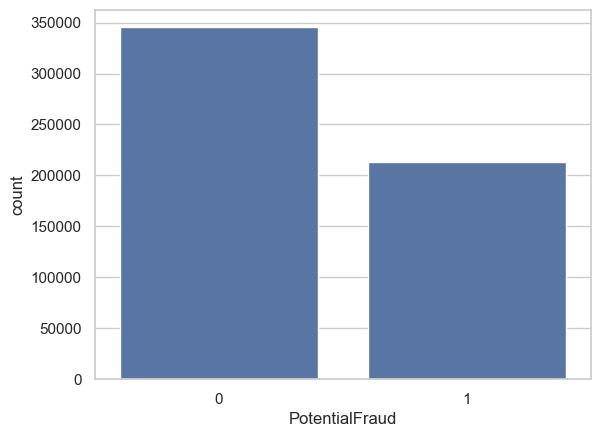

In [179]:
# check labels
print(df.PotentialFraud.value_counts())
sns.countplot(x='PotentialFraud', data=df)
# The dataset is imbalanced.

In [180]:
#show null values amount
print('null value amount:\n', df.isna().sum())

#show null values percentage
print('null value percentage:\n', df.isnull().mean()*100)

#figure out high percentage columns
nullPercent = df.isnull().mean()*100
filtered_columns = nullPercent[nullPercent > 70].index
print(filtered_columns)



null value amount:
 BeneID                                  0
ClaimID                                 0
ClaimStartDt                            0
ClaimEndDt                              0
Provider                                0
InscClaimAmtReimbursed                  0
AttendingPhysician                   1508
OperatingPhysician                 443764
OtherPhysician                     358475
ClmDiagnosisCode_1                  10453
ClmDiagnosisCode_2                 195606
ClmDiagnosisCode_3                 315156
ClmDiagnosisCode_4                 393675
ClmDiagnosisCode_5                 446287
ClmDiagnosisCode_6                 473819
ClmDiagnosisCode_7                 492034
ClmDiagnosisCode_8                 504767
ClmDiagnosisCode_9                 516396
ClmDiagnosisCode_10                553201
ClmProcedureCode_1                 534901
ClmProcedureCode_2                 552721
ClmProcedureCode_3                 557242
ClmProcedureCode_4                 558093
ClmProcedureCo

###### check duplicates

In [181]:
#Checking how many distinct BeneID we have in our data
print(len(list(df.BeneID.value_counts()==1)))
print(len(list(df['BeneID'].unique())))

138556
138556


In [182]:
#Checking how many distinct BeneID we have in our data
print(len(list(df.ClaimID.value_counts()==1)))
print(len(list(df['ClaimID'].unique())))

558211
558211


Conclusion:

1. We have data for 138556 BeneID.Means one beneficiarty has applied for claim mulriple times
2. Also we have 558211 distinct claimsID,means we have seperate record for each benefiacry every time he appliedd for claims
3. No duplicate rows are present in our dataset

##### Feature Engineering


###### Feature creation

In [183]:
#Adding a column is_dead  = 1  DOD is given else is_dead = 0 
df['Is_Dead'] = np.where(df['DOD'].isnull(), 0, 1)

In [184]:
#Add column age
# Convert 'DOB' and 'ClaimStartDt' columns to datetime format
df['DOB'] =  pd.to_datetime(df['DOB'], format='%Y-%m-%d')  
df['ClaimStartDt'] = pd.to_datetime(df['ClaimStartDt'], format='%Y-%m-%d')  
df['Age'] = (df['ClaimStartDt'] - df['DOB']).dt.days // 365


In [185]:
#calculate number of hospital stays
#outpatients don't get admitted so we keep 0 for them
df['AdmissionDt'] = pd.to_datetime(df['AdmissionDt'] , format = '%Y-%m-%d')
df['DischargeDt'] = pd.to_datetime(df['DischargeDt'],format = '%Y-%m-%d')
df['Hperiod'] = ((df['DischargeDt'] - df['AdmissionDt']).dt.days)+1
df.loc[df['is_admitted'] == 0, 'Hperiod'] = 0



In [186]:
# calculate the period of claims
startdate = pd.to_datetime(df.ClaimStartDt)
enddate = pd.to_datetime(df.ClaimEndDt)
df['Cperiod'] = (enddate - startdate).dt.days+1

In [187]:
#check for same physician in all three physician columns
def physician_same(row):
    atten_oper = row['AttendingPhysician'] == row['OperatingPhysician']
    oper_other = row['OperatingPhysician'] == row['OtherPhysician']
    atten_other = row['AttendingPhysician'] == row['OtherPhysician']
    
    # atten = oper = other
    if atten_oper == True and oper_other == True:
        return 0
    
    # atten = oper != other
    elif atten_oper == True and oper_other == False:
        return 1
    
    # atten = other != oper
    elif atten_other == True and oper_other == False:
        return 2
    
    # atten != other = oper
    elif atten_other == False and oper_other == True:
        return 3
    
    # atten != other != oper
    else:
        return 4


df['phy_same'] = df.apply(physician_same, axis=1)

In [188]:
# count unique physicians in each claim
def N_unique_values(df):
    """This function finds the unique values in a df row"""
    return np.array([len(set([i for i in x[~pd.isnull(x)]])) for x in df.values])

df['N_unique_Physicians'] = N_unique_values(df[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']]) 

In [189]:
# count how many dx and proc a claim has
Diag_proce_col = ['ClmAdmitDiagnosisCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_10',
                  'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
                  'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7',
                  'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmProcedureCode_1',
                  'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
                  'ClmProcedureCode_5', 'ClmProcedureCode_6']

for i in Diag_proce_col:
    df[i][df[i]!=0]= 1

df[Diag_proce_col]= df[Diag_proce_col].astype(float)


df[Diag_proce_col].head(5)

,ClmAdmitDiagnosisCode,ClmDiagnosisCode_1,ClmDiagnosisCode_10,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [190]:
#adding column total_num_diag
df['total_num_diag'] = 0 
diagnosis_col = ['ClmDiagnosisCode_1','ClmDiagnosisCode_2','ClmDiagnosisCode_3','ClmDiagnosisCode_4','ClmDiagnosisCode_5','ClmDiagnosisCode_6','ClmDiagnosisCode_7','ClmDiagnosisCode_8','ClmDiagnosisCode_9','ClmDiagnosisCode_10']

for col in diagnosis_col :
    df['total_num_diag']  +=  df[col]

In [191]:
#adding column total_num_proce
df['total_num_proce'] = 0 
procedure_col = ['ClmProcedureCode_1','ClmProcedureCode_2','ClmProcedureCode_3','ClmProcedureCode_4','ClmProcedureCode_5','ClmProcedureCode_6']

for col in procedure_col :
    df['total_num_proce']  = df['total_num_proce'] + df[col]

In [192]:
df['total_num_diag'] =  df['total_num_diag'].astype(float)
df['total_num_proce'] =  df['total_num_proce'].astype(float)

In [193]:
# Group by 'BeneID' and calculate total amount and count of claims
grouped = df.groupby('BeneID')['InscClaimAmtReimbursed'].agg(['sum', 'count'])

# Calculate mean amount for each 'BeneID'
grouped['mean'] = grouped['sum'] / grouped['count']

# Merge with df to get 'BeneID' and corresponding statistics
df = df.merge(grouped, left_on='BeneID', right_index=True, how='left')

print("Dataset shape : ", df.shape)
df.head(5)



Dataset shape :  (558211, 67)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,Age,Hperiod,Cperiod,phy_same,N_unique_Physicians,total_num_diag,total_num_proce,sum,count,mean
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,1.0,...,73,0.0,1,4,1,10.0,6.0,30,1,30.000000
1,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,1.0,...,86,0.0,1,4,1,10.0,6.0,1810,12,150.833333
2,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,1.0,...,86,0.0,1,4,1,10.0,6.0,1810,12,150.833333
3,BENE11004,CLM173224,2009-02-03,2009-02-03,PRV56011,20,PHY339887,NaN,NaN,1.0,...,86,0.0,1,4,1,10.0,6.0,1810,12,150.833333
4,BENE11004,CLM224741,2009-03-03,2009-03-03,PRV56011,40,PHY345721,NaN,NaN,1.0,...,86,0.0,1,4,1,10.0,6.0,1810,12,150.833333


###### deal with null values

In [194]:
# replace null values with 0
df.loc[df['DeductibleAmtPaid'].isnull(), 'DeductibleAmtPaid'] = 0
df[Diag_proce_col]= df[Diag_proce_col].replace({np.nan:0})
df['DiagnosisGroupCode']= df['DiagnosisGroupCode'].replace({np.nan:0})

df.head(5)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,Age,Hperiod,Cperiod,phy_same,N_unique_Physicians,total_num_diag,total_num_proce,sum,count,mean
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,1.0,...,73,0.0,1,4,1,10.0,6.0,30,1,30.000000
1,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,1.0,...,86,0.0,1,4,1,10.0,6.0,1810,12,150.833333
2,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,1.0,...,86,0.0,1,4,1,10.0,6.0,1810,12,150.833333
3,BENE11004,CLM173224,2009-02-03,2009-02-03,PRV56011,20,PHY339887,NaN,NaN,1.0,...,86,0.0,1,4,1,10.0,6.0,1810,12,150.833333
4,BENE11004,CLM224741,2009-03-03,2009-03-03,PRV56011,40,PHY345721,NaN,NaN,1.0,...,86,0.0,1,4,1,10.0,6.0,1810,12,150.833333


###### Encoding

<Axes: title={'center': 'Top 5 sucpicious Diagnosis'}, xlabel='DiagnosisCode'>

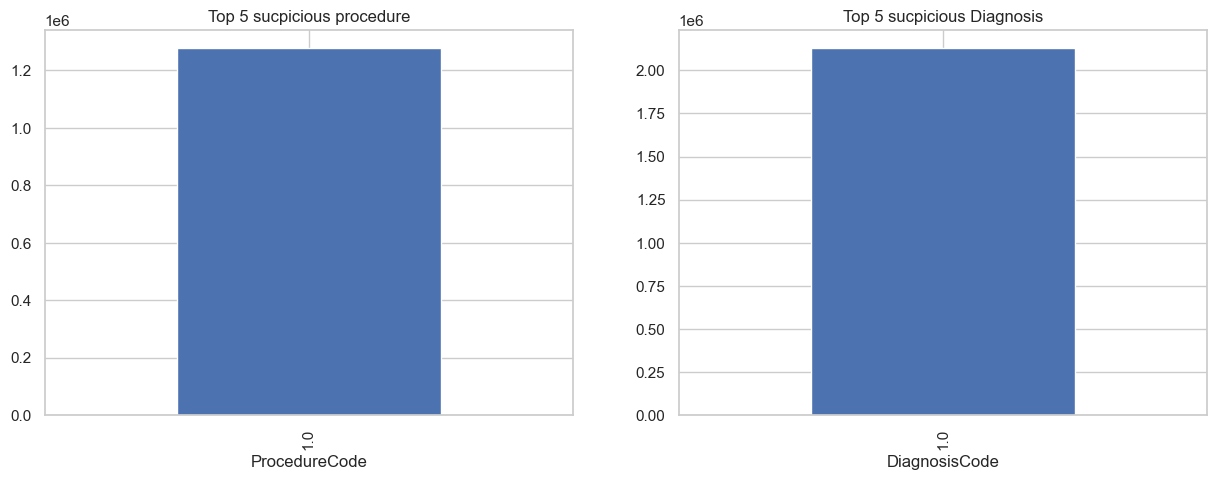

In [195]:
# encode procedure code and dx code
potential_fraud_df =df.loc[df['PotentialFraud'] == 1]

df1 = pd.DataFrame(columns = ['ProcedureCode'])
df1['ProcedureCode'] = pd.concat([potential_fraud_df["ClmProcedureCode_1"], 
                                           potential_fraud_df["ClmProcedureCode_2"],
                                           potential_fraud_df["ClmProcedureCode_3"],
                                           potential_fraud_df["ClmProcedureCode_4"], 
                                           potential_fraud_df["ClmProcedureCode_5"], 
                                           potential_fraud_df["ClmProcedureCode_6"]], axis=0, sort=True).dropna()

df2 = pd.DataFrame(columns = ['DiagnosisCode'])
df2['DiagnosisCode'] = pd.concat([potential_fraud_df["ClmDiagnosisCode_1"], 
                                           potential_fraud_df["ClmDiagnosisCode_2"], 
                                           potential_fraud_df["ClmDiagnosisCode_3"], 
                                           potential_fraud_df["ClmDiagnosisCode_4"],
                                           potential_fraud_df["ClmDiagnosisCode_5"], 
                                           potential_fraud_df["ClmDiagnosisCode_6"],
                                           potential_fraud_df["ClmDiagnosisCode_7"],
                                           potential_fraud_df["ClmDiagnosisCode_8"],
                                           potential_fraud_df["ClmDiagnosisCode_9"],
                                           potential_fraud_df["ClmDiagnosisCode_10"]], axis=0, sort=True).dropna()
plt.figure(figsize=(15, 5))
plt.subplot(121)
df1.ProcedureCode.value_counts().head(5).plot(kind = 'bar' , title ='Top 5 sucpicious procedure')

plt.subplot(122)
df2.DiagnosisCode.value_counts().head(5).plot(kind = 'bar' , title ='Top 5 sucpicious Diagnosis')

In [196]:
# method 1: apply one-hot encoding on all proc code and dx code(don't consider the seq)

procedure_col = ['ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6']

# Step 1: Extract procedure codes from specified columns
procedure_codes = df[procedure_col]

# Step 2: Concatenate the procedure codes into a single DataFrame
procedure_codes_concat = pd.concat([procedure_codes[col] for col in procedure_col], axis=0, ignore_index=True)

# Step 3: One-hot encode the procedure codes
procedure_codes_encoded = pd.get_dummies(procedure_codes_concat, prefix='Procedure')
procedure_codes_encoded

# It will cause sparse data.

,Procedure_1.0
0,True
1,True
2,True
3,True
4,True
...,...
3349261,True
3349262,True
3349263,True
3349264,True


In [197]:
# method 2: encode top 5 proc code and dx code only
def encoded_cat(dataset, feature_to_encode='',col_list=[]):
    """This function returns top 5 cat column useful in determining potential fraud"""
    outer_list =[]
    for col in col_list:
        list_1 = list()
        
        for item in list(dataset[col]):
            if str(item) == str(feature_to_encode):
                list_1.append(1)
            else:
                list_1.append(0)
        
        outer_list.append(list_1)
    
    li_sum = np.array([0]*558211)
    
    for i in range(0,len(outer_list)):
        li1 = np.array(outer_list[i])
        li_sum = li_sum + li1
        
    return li_sum


#encode top 5 procedure
# 4019.0, 2724.0, 9904.0, 8154.0, 66.0
df['pr_4019'] = encoded_cat(df,'4019.0',procedure_col)
df['pr_2724'] = encoded_cat(df,'2724.0',procedure_col)
df['pr_9904'] = encoded_cat(df,'9904.0',procedure_col)
df['pr_8154'] = encoded_cat(df,'8154.0',procedure_col)
df['pr_66'] =   encoded_cat(df,'66.0',procedure_col)

#encode top 5 diagnosis 
#4019,25000,2724,V5869,42731
df['di_4019'] = encoded_cat(df,'4019',diagnosis_col)
df['di_25000'] = encoded_cat(df,'25000',diagnosis_col)
df['di_2724'] = encoded_cat(df,'2724',diagnosis_col)
df['di_V5869'] = encoded_cat(df,'V5869',diagnosis_col)
df['di_42731'] =   encoded_cat(df,'42731',diagnosis_col)

df

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,pr_4019,pr_2724,pr_9904,pr_8154,pr_66,di_4019,di_25000,di_2724,di_V5869,di_42731
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,1.0,...,0,0,0,0,0,0,0,0,0,0
1,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,1.0,...,0,0,0,0,0,0,0,0,0,0
2,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,1.0,...,0,0,0,0,0,0,0,0,0,0
3,BENE11004,CLM173224,2009-02-03,2009-02-03,PRV56011,20,PHY339887,NaN,NaN,1.0,...,0,0,0,0,0,0,0,0,0,0
4,BENE11004,CLM224741,2009-03-03,2009-03-03,PRV56011,40,PHY345721,NaN,NaN,1.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,BENE57978,CLM37910,2009-02-11,2009-02-16,PRV53511,0,PHY378514,PHY426843,NaN,1.0,...,0,0,0,0,0,0,0,0,0,0
558207,BENE80245,CLM79653,2009-12-15,2009-12-18,PRV51711,4000,PHY345109,NaN,NaN,1.0,...,0,0,0,0,0,0,0,0,0,0
558208,BENE85177,CLM77745,2009-11-29,2009-12-07,PRV54503,8000,PHY418343,NaN,NaN,1.0,...,0,0,0,0,0,0,0,0,0,0
558209,BENE105577,CLM53155,2009-05-28,2009-05-31,PRV51239,5000,PHY382916,NaN,NaN,1.0,...,0,0,0,0,0,0,0,0,0,0


In [198]:
#encoding types of physicians into numeric values
df[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']] = np.where(df[['AttendingPhysician','OperatingPhysician','OtherPhysician']].isnull(), 0, 1)

# number of different physicians who attend a patient
df['N_Types_Physicians'] = df['AttendingPhysician'] +  df['OperatingPhysician'] + df['OtherPhysician']


In [199]:
#final check to see if a col val is NaN
col_inf_df=pd.DataFrame() 
val = df.isnull().sum()
col_inf_df['null_col_count']  = val
col_inf_df['column'] = val.index
col_inf_df.loc[col_inf_df['null_col_count'] !=0]

,null_col_count,column
AdmissionDt,517737,AdmissionDt
DischargeDt,517737,DischargeDt
DOD,554080,DOD


###### Feature deletion

In [200]:
# Drop irrelevant columns
col_to_remove = ['Provider','BeneID', 'ClaimID', 'ClaimStartDt','ClaimEndDt','AdmissionDt', 'DischargeDt', 'DOB', 'DOD','AttendingPhysician',\
                 'OperatingPhysician', 'OtherPhysician','ClmAdmitDiagnosisCode','NoOfMonths_PartACov',\
                 'NoOfMonths_PartBCov','DiagnosisGroupCode']

df.drop(columns=col_to_remove, axis=1, inplace=True)
df['PotentialFraud']=df['PotentialFraud'].astype(int)

df.head()


,InscClaimAmtReimbursed,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,...,pr_2724,pr_9904,pr_8154,pr_66,di_4019,di_25000,di_2724,di_V5869,di_42731,N_Types_Physicians
0,30,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1
1,40,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1
2,200,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1
3,20,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1
4,40,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1


In [201]:
df['PotentialFraud'].value_counts()


PotentialFraud
0    345415
1    212796
Name: count, dtype: int64

In [202]:
y = df['PotentialFraud']
X = df.drop('PotentialFraud', axis=1)

In [203]:
X.columns

Index(['InscClaimAmtReimbursed', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'is_admitted', 'Gender', 'Race', 'RenalDiseaseIndicator', 'State',
       'County', 'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
       'OPAnnualDeductibleAmt', 'Is_Dead', 'Ag

<Axes: >

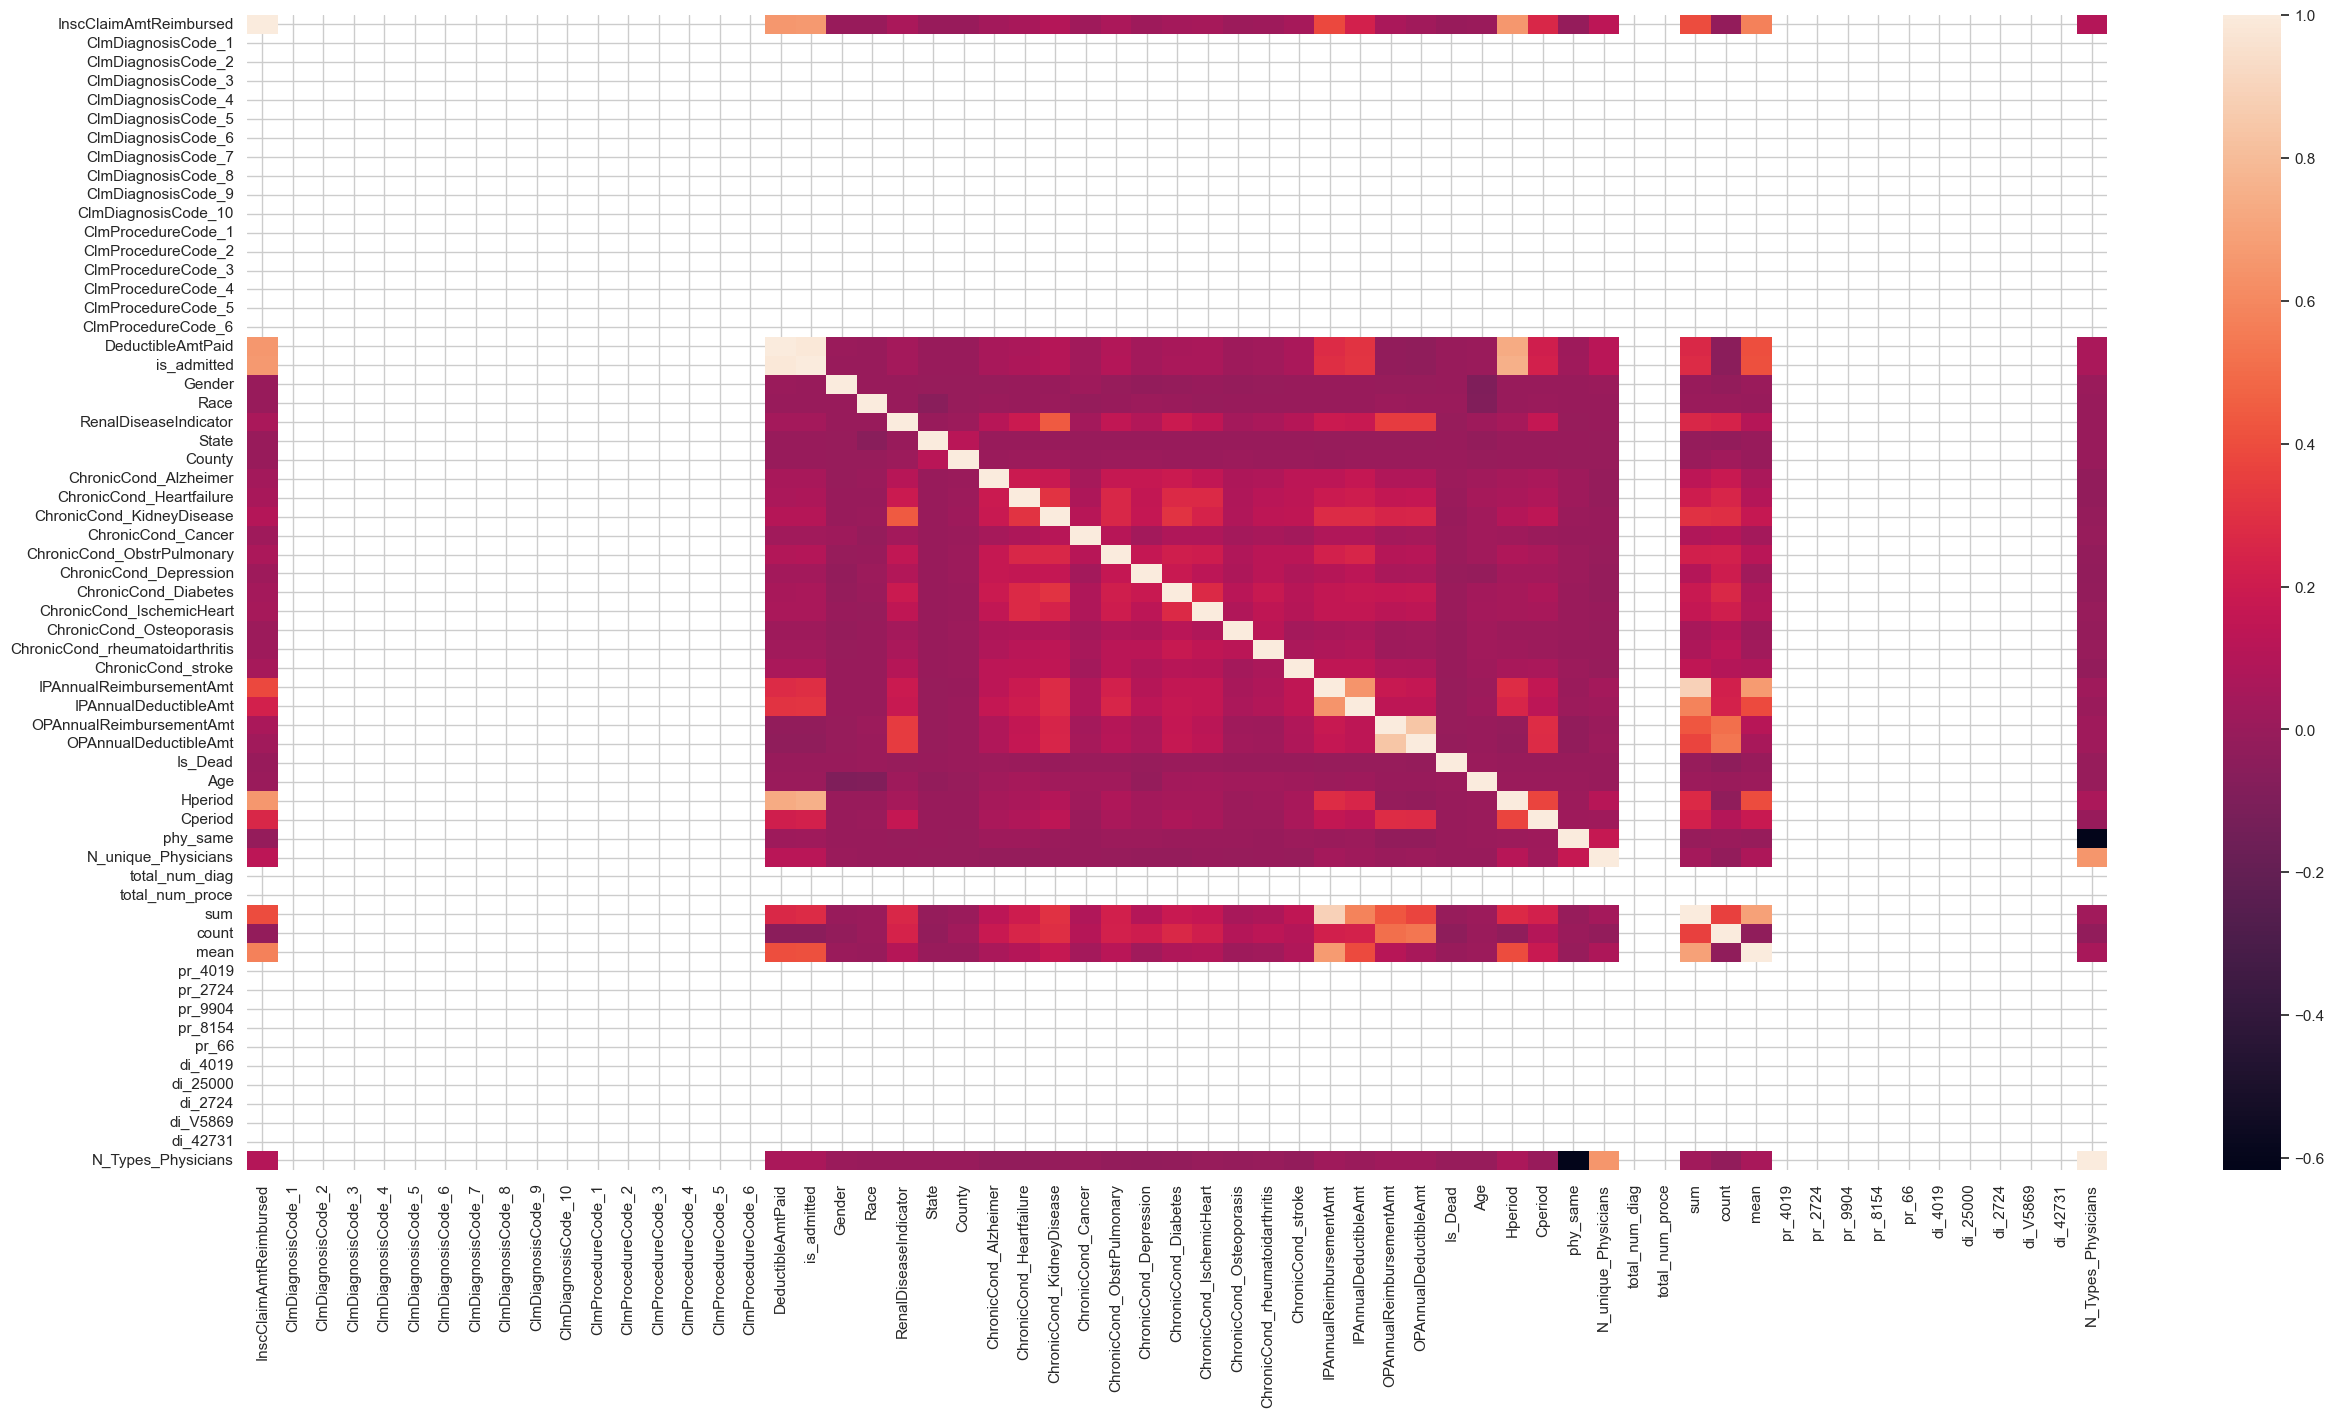

In [204]:
#plot correlation heat map between features
sns.set(context='notebook', style='whitegrid')
plt.figure(figsize=(30, 15))
corr = X.corr()
sns.heatmap(corr, annot=False)

In [224]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)


print("Shapes data into train,test,CV splitting..")
print("Training X : ",X_train.shape," | Training Y : ",y_train.shape)
print("Test X : ",X_test.shape," | Test Y : ",y_test.shape)

Shapes data into train,test,CV splitting..
Training X :  (374001, 61)  | Training Y :  (374001,)
Test X :  (184210, 61)  | Test Y :  (184210,)


###### Normalization - Handling Numerical Column

In [234]:
# calculates and stores the parameters necessary for normalization based on the training data.
def num_col_normalizer(X_tr,X_te,col=''):
    """This function retruns normalised column for train and test data"""
    normalizer = Normalizer()
    
    normalizer.fit(X_tr[col].values.reshape(-1,1))
    
    tr = normalizer.transform(X_tr[col].values.reshape(-1,1)).reshape(-1,1)
    te = normalizer.transform(X_te[col].values.reshape(-1,1)).reshape(-1,1)
    
    return tr,te


# Columns to normalize
columns_to_normalize = [
    'InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
       'OPAnnualDeductibleAmt',  'Hperiod', 'Cperiod',
       'total_num_diag', 'total_num_proce',
       'sum', 'count', 'mean', 
       'N_Types_Physicians'
]


# Normalize each column in train and test data
for col in tqdm_notebook(columns_to_normalize):
    tr, te = num_col_normalizer(X_train, X_test, col)
    X_train[col] = tr
    X_test[col] = te


  0%|          | 0/14 [00:00<?, ?it/s]

In [235]:
X_train.head(5)


,InscClaimAmtReimbursed,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,...,pr_2724,pr_9904,pr_8154,pr_66,di_4019,di_25000,di_2724,di_V5869,di_42731,N_Types_Physicians
237775,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0
430770,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0
38430,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0
423947,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0
96804,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0


In [236]:
X_test.head(5)


,InscClaimAmtReimbursed,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,...,pr_2724,pr_9904,pr_8154,pr_66,di_4019,di_25000,di_2724,di_V5869,di_42731,N_Types_Physicians
103748,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0
6888,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0
80070,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0
56513,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0
206271,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0


#### EDA

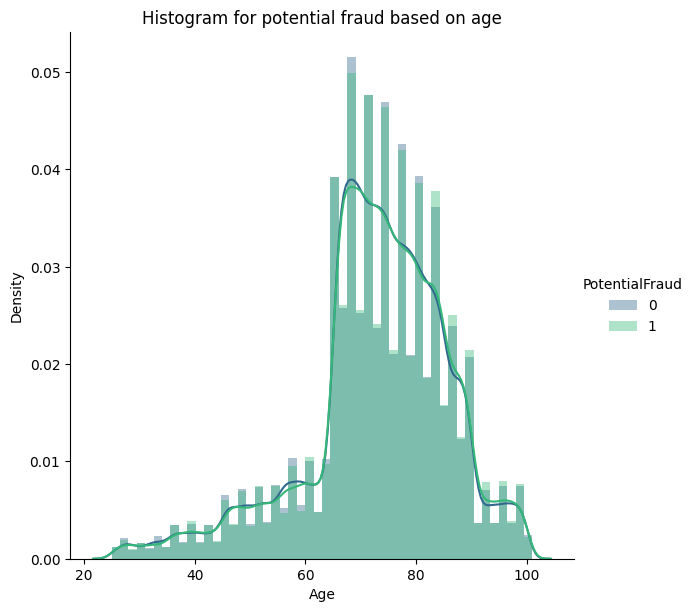

<Figure size 640x480 with 0 Axes>

In [115]:
# sns.distplot(df['Age'])
# plt.title('Histogram for Age')
#plotting age
sns.FacetGrid(df, hue="PotentialFraud" , height=6, palette='viridis').map(sns.distplot, "Age",).add_legend()
plt.title('Histogram for potential fraud based on age')
plt.show()
plt.tight_layout()

##### Age:

1. We don't see any differnce in distribution of age that may enable us to flag potential fraud.
2. But we see increasing trend in the potential fraud cases for patients age > 65 Also most of the patient who applied for claim fall in this age range only

Text(0.5, 1.0, 'Plot to Analyse relation between Race and fraud/not fraud')

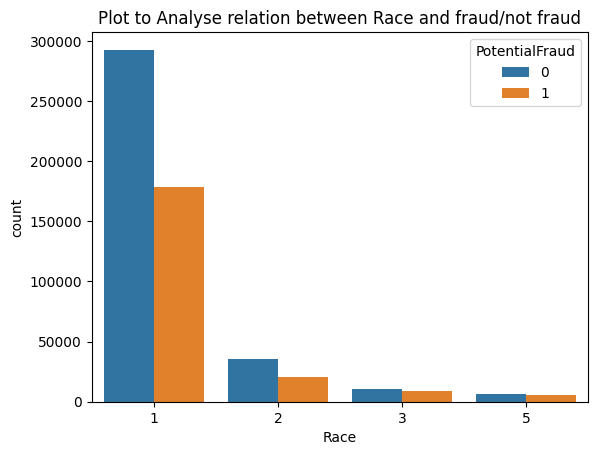

In [113]:
ax = sns.countplot(x='Race',data=df,hue='PotentialFraud')
ax.set_title("Plot to Analyse relation between Race and fraud/not fraud")

##### Race:

1. It is very important to see that most fradulent cases is with patients belonging to a perticular Race and that is labelled as 1

In [10]:
# deal with dx code and proc code
# Applying coalesce function to dx columns 
# filling dx_1 by other dx columns  
df['ClmDiagnosisCode_1'] = df[[f'ClmDiagnosisCode_{i}' for i in range(1, 11)]].fillna(method='ffill', axis=1)['ClmDiagnosisCode_1']
df['ClmDiagnosisCode_2'] = df[[f'ClmDiagnosisCode_{i}' for i in range(2, 11)]].fillna(method='ffill', axis=1)['ClmDiagnosisCode_2']
df['ClmDiagnosisCode_3'] = df[[f'ClmDiagnosisCode_{i}' for i in range(3, 11)]].fillna(method='ffill', axis=1)['ClmDiagnosisCode_3']


# Applying coalesce function to proc columns 
df['ClmProcedureCode_1'] = df[[f'ClmProcedureCode_{i}' for i in range(1, 7)]].fillna(method='ffill', axis=1)['ClmProcedureCode_1']
df['ClmProcedureCode_2'] = df[[f'ClmProcedureCode_{i}' for i in range(2, 7)]].fillna(method='ffill', axis=1)['ClmProcedureCode_2']



In [50]:
#show null values amount
print('null value amount:\n', df.isna().sum())

#show null values percentage
print('null value percentage:\n', df.isnull().mean()*100)

#figure out high percentage columns
nullPercent = df.isnull().mean()*100
filtered_columns = nullPercent[nullPercent > 70].index
print(filtered_columns)

null value amount:
 BeneID                 0
ClaimID                0
ClaimStartDt           0
ClaimEndDt             0
Provider               0
                      ..
di_2724                0
di_V5869               0
di_42731               0
N_unique_Physicians    0
N_Types_Physicians     0
Length: 81, dtype: int64
null value percentage:
 BeneID                 0.0
ClaimID                0.0
ClaimStartDt           0.0
ClaimEndDt             0.0
Provider               0.0
                      ... 
di_2724                0.0
di_V5869               0.0
di_42731               0.0
N_unique_Physicians    0.0
N_Types_Physicians     0.0
Length: 81, dtype: float64
Index(['AdmissionDt', 'DischargeDt', 'DOD'], dtype='object')


In [12]:
# three methods to deal with dx columns and proc columns
# method 1: drop columns where null values percentage > 70%
# remove columns which null value percentage is larger than 70% after processing
df = df.drop(['ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6'], axis = 1)

In [ ]:
# method 2: concatenate all the dx code and apply one-hot encoding (don't consider the seq)



In [ ]:
# method 3: concatenate all the dx code and apply one-hot encoding (consider the seq)



check for same physician in all three physician columns

In [22]:
# check whether the data is balanced
# 38% positive cases
df['PotentialFraud'].unique()
(df['PotentialFraud'] == "Yes").sum() /len(df)




0.3812106891480103

one hot encoding for the categorical features

In [56]:
from sklearn.preprocessing import OneHotEncoder     # One Hot Encoding 

encoder = OneHotEncoder()
one_hot = encoder.fit_transform(df[['Gender']]).toarray()

# df = pd.concat([df, pd.DataFrame(one_hot, columns=encoder.get_feature_names())], axis=1)


# print(df)